# Face detection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd drive/My Drive

/content/drive/My Drive


### Changing current working directory to project folder

In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Face detection project")

### Loading the "images.npy" file containing images with details of boundin box

In [0]:
import numpy as np

In [0]:
data = np.load('images.npy', allow_pickle=True)

In [7]:
data.shape

(409, 2)

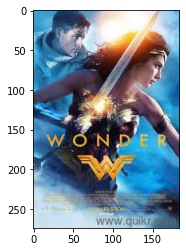

In [8]:
from matplotlib import pyplot as plt

plt.imshow(data[9,0], cmap='gray')
plt.show()

### Set image dimensions

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [0]:
HEIGHT_CELLS = 224
WIDTH_CELLS = 224

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [12]:
X_train.shape

(409, 224, 224, 3)

In [13]:
masks.shape

(409, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

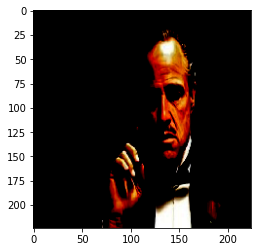

In [14]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

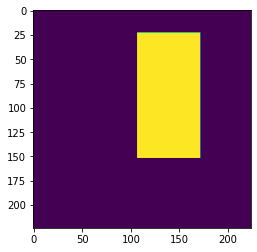

In [15]:
pyplot.imshow(masks[n])

## Create the model

In [0]:
IMAGE_HEIGHT=224
IMAGE_WIDTH=224

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model


def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")
    for layer in model.layers:
        layer.trainable = trainable

    block_1 = model.get_layer("conv_pw_1_relu").output
    block0 = model.get_layer("conv_pw_3_relu").output
    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block_1])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x)
    print(x.shape)
        

    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [18]:
model = create_model(True)

model.summary()

17227776/17225924 [==============================] - 0s 0us/step
(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
co

### Calculate dice coefficient


In [0]:
import tensorflow as tf

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model

In [0]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [0]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model

In [0]:
EPOCHS=1
BATCH_SIZE = 4

In [26]:
model.fit(X_train, masks, epochs=EPOCHS, verbose=1, batch_size=1, callbacks=[checkpoint, reduce_lr, stop])

409/409 [==============================] - ETA: 0s - loss: 1.3753 - dice_coefficient: 0.4438
Epoch 00001: loss improved from inf to 1.37534, saving model to model-1.38.h5
409/409 [==============================] - 42s 102ms/step - loss: 1.3753 - dice_coefficient: 0.4438 - lr: 1.0000e-04


### Get the predicted mask for a sample image

In [0]:
n = 100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


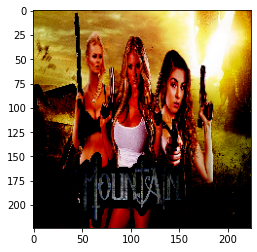

In [87]:
sample_image = X_train[n]
pyplot.imshow(sample_image)
plt.savefig('sample_image.png')

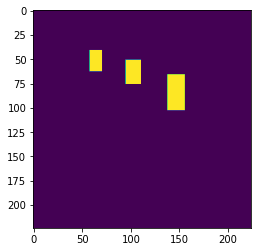

In [88]:
sample_mask = masks[n]
pyplot.imshow(sample_mask)
plt.savefig('sample_mask.png')

In [0]:
predicted_masked = model.predict(x=np.array([sample_image]))[0]

In [71]:
predicted_masked

array([[2.7742778e-04, 2.7742778e-04, 2.5315201e-04, ..., 3.1826252e-04,
        2.9860827e-04, 2.9860827e-04],
       [2.7742778e-04, 2.7742778e-04, 2.5315201e-04, ..., 3.1826252e-04,
        2.9860827e-04, 2.9860827e-04],
       [2.0032437e-04, 2.0032437e-04, 2.1632963e-04, ..., 3.5313176e-04,
        2.6825207e-04, 2.6825207e-04],
       ...,
       [1.4062983e-04, 1.4062983e-04, 1.3262610e-04, ..., 7.1270020e-05,
        7.1827795e-05, 7.1827795e-05],
       [1.8609014e-04, 1.8609014e-04, 1.3952427e-04, ..., 5.2259398e-05,
        8.9453773e-05, 8.9453773e-05],
       [1.8609014e-04, 1.8609014e-04, 1.3952427e-04, ..., 5.2259398e-05,
        8.9453773e-05, 8.9453773e-05]], dtype=float32)

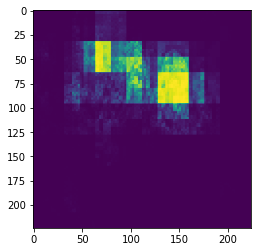

In [89]:
pyplot.imshow(predicted_masked)
plt.savefig('predicted_masked.png')

### Impose the mask on the image (5 marks)

In [0]:
import cv2

src1 = cv2.imread('sample_image.png')
src2 = cv2.imread('predicted_masked.png')

src2 = cv2.resize(src2, src1.shape[1::-1])

In [91]:
dst = cv2.addWeighted(src1, 0.5, src2, 0.5, 0)

cv2.imwrite('imposed_image.png', dst)

True

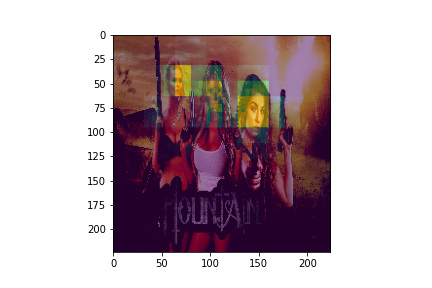

In [95]:
from google.colab.patches import cv2_imshow
#cv2_imshow('imposed_image.png')

img = cv2.imread('imposed_image.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)